In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
import pandas as pd
import numpy as np
import random
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import label, regionprops

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

SEED = 111
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 12})

CLASS_TYPES = ['glioma', 'meningioma', 'notumor', 'pituitary']
N_TYPES = len(CLASS_TYPES)


In [2]:
@keras.utils.register_keras_serializable()
class ChannelAttention(layers.Layer):
    def __init__(self, channels, reduction=16, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.reduction = reduction
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.fc1 = layers.Dense(channels // reduction, use_bias=False, activation='relu')
        self.fc2 = layers.Dense(channels, use_bias=False)
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg = self.fc2(self.fc1(self.avg_pool(x)))
        maxp = self.fc2(self.fc1(self.max_pool(x)))
        out = self.sigmoid(avg + maxp)
        out = tf.reshape(out, (-1, 1, 1, self.channels))
        return x * out

    def get_config(self):
        config = super().get_config()
        config.update({"channels": self.channels, "reduction": self.reduction})
        return config

@keras.utils.register_keras_serializable()
class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
        self.conv = layers.Conv2D(1, kernel_size, padding='same', use_bias=False)
        self.sigmoid = layers.Activation('sigmoid')

    def call(self, x):
        avg_out = tf.reduce_mean(x, axis=3, keepdims=True)
        max_out = tf.reduce_max(x, axis=3, keepdims=True)
        concat = tf.concat([avg_out, max_out], axis=3)
        out = self.sigmoid(self.conv(concat))
        return x * out

    def get_config(self):
        config = super().get_config()
        config.update({"kernel_size": self.kernel_size})
        return config

@keras.utils.register_keras_serializable()
class CBAM(layers.Layer):
    def __init__(self, channels, reduction=16, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.reduction = reduction
        self.kernel_size = kernel_size
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(kernel_size)

    def call(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "channels": self.channels,
            "reduction": self.reduction,
            "kernel_size": self.kernel_size
        })
        return config


In [3]:
zip_path = '/content/dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

USER_PATH = "/content/dataset"
USER_PATH_PREPROCESSED = "/content/dataset1"

train_dir = os.path.join(USER_PATH, 'Training')
test_dir = os.path.join(USER_PATH, 'Testing')

os.makedirs(USER_PATH_PREPROCESSED, exist_ok=True)

total_train = sum([len(os.listdir(os.path.join(train_dir, c)))
                   for c in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, c))])
total_test = sum([len(os.listdir(os.path.join(test_dir, c)))
                  for c in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, c))])

print(f"Training images: {total_train}")
print(f"Testing images: {total_test}")


Training images: 5712
Testing images: 1311


In [4]:
def load_images_from_folder(folder, target_size=(240, 240)):
    images = []
    labels = []
    image_paths = []

    for class_name in CLASS_TYPES:
        class_folder = os.path.join(folder, class_name)
        if not os.path.exists(class_folder):
            continue

        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, target_size)

                    images.append(img)
                    labels.append(class_name)
                    image_paths.append(img_path)
                except:
                    pass

    return np.array(images), np.array(labels), image_paths

def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return enhanced

train_images_original, train_labels, train_paths = load_images_from_folder(train_dir)
test_images_original, test_labels, test_paths = load_images_from_folder(test_dir)

label_encoder = LabelEncoder()
label_encoder.fit(CLASS_TYPES)
train_labels_encoded = label_encoder.transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

train_images_clahe = np.array([apply_clahe(img) for img in train_images_original])
test_images_clahe = np.array([apply_clahe(img) for img in test_images_original])

print(f"Loaded {len(train_images_original)} training images")
print(f"Loaded {len(test_images_original)} testing images")


Loaded 5712 training images
Loaded 1311 testing images


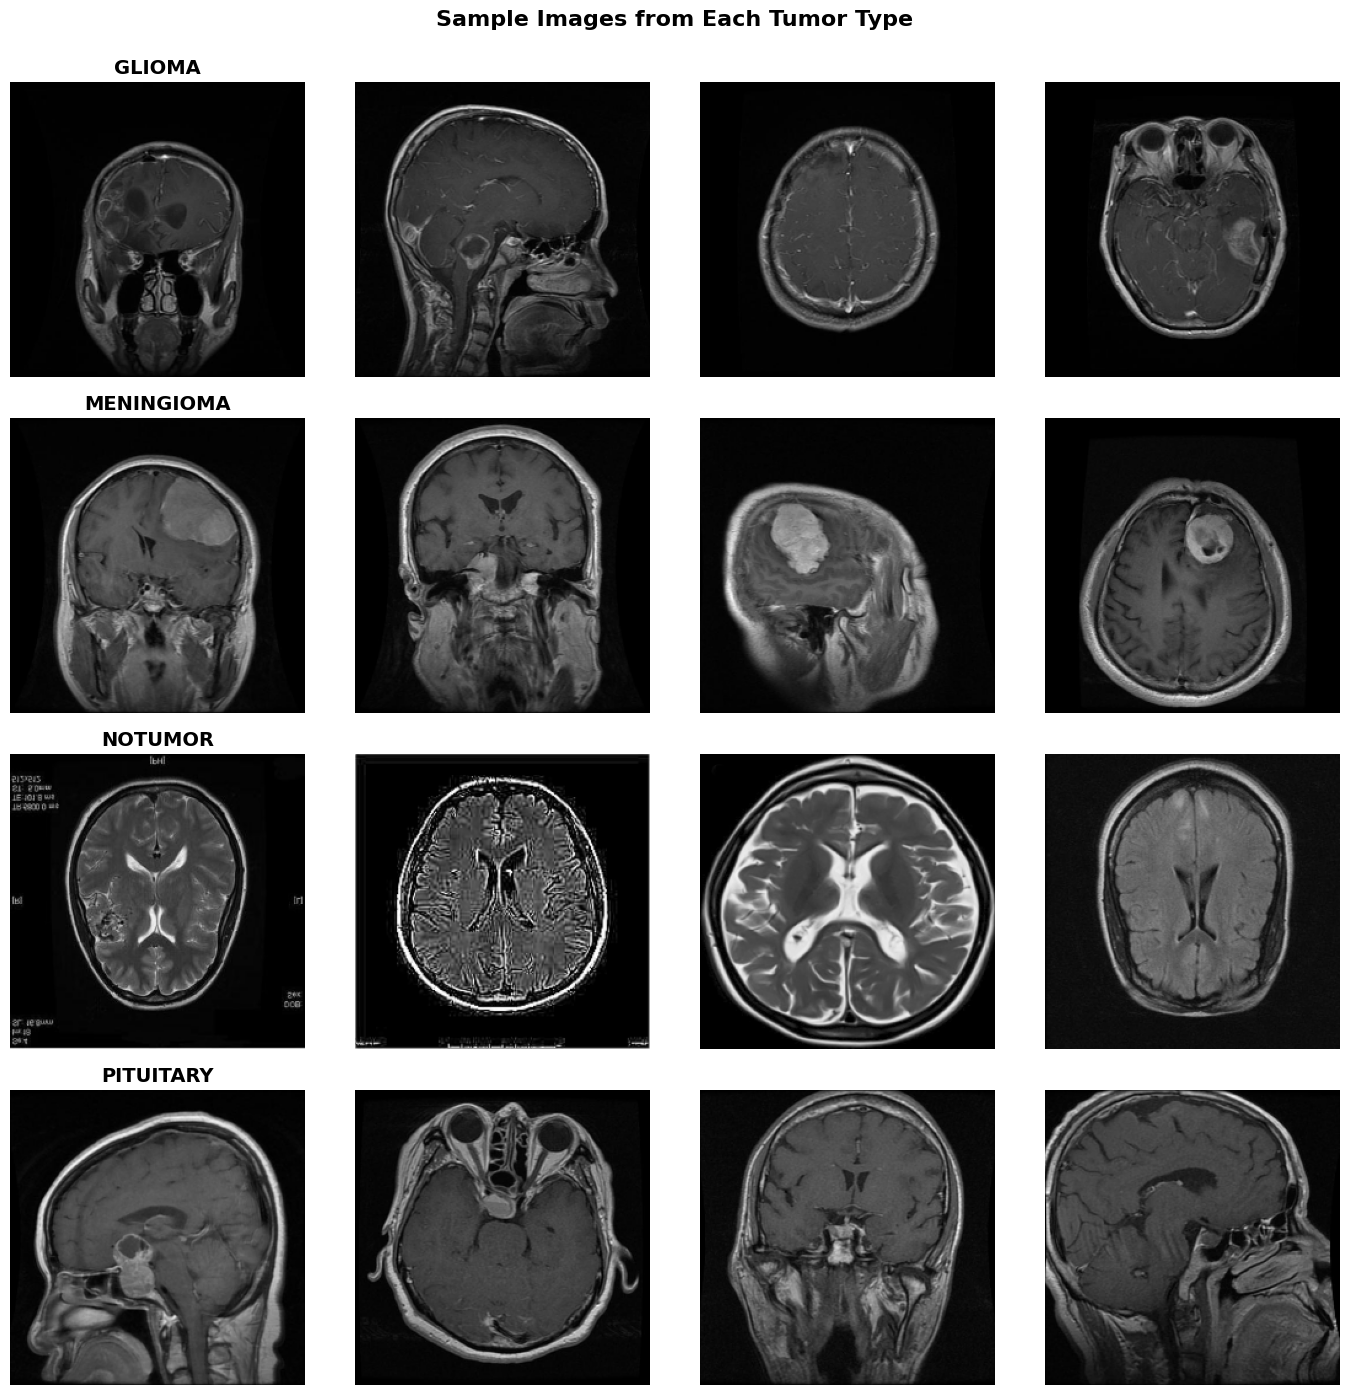

In [5]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))

for i, class_name in enumerate(CLASS_TYPES):
    class_indices = np.where(train_labels == class_name)[0]
    samples = np.random.choice(class_indices, 4, replace=False)

    for j, idx in enumerate(samples):
        axes[i, j].imshow(train_images_original[idx])
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'{class_name.upper()}', fontweight='bold', fontsize=14)

plt.suptitle('Sample Images from Each Tumor Type',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
plt.show()


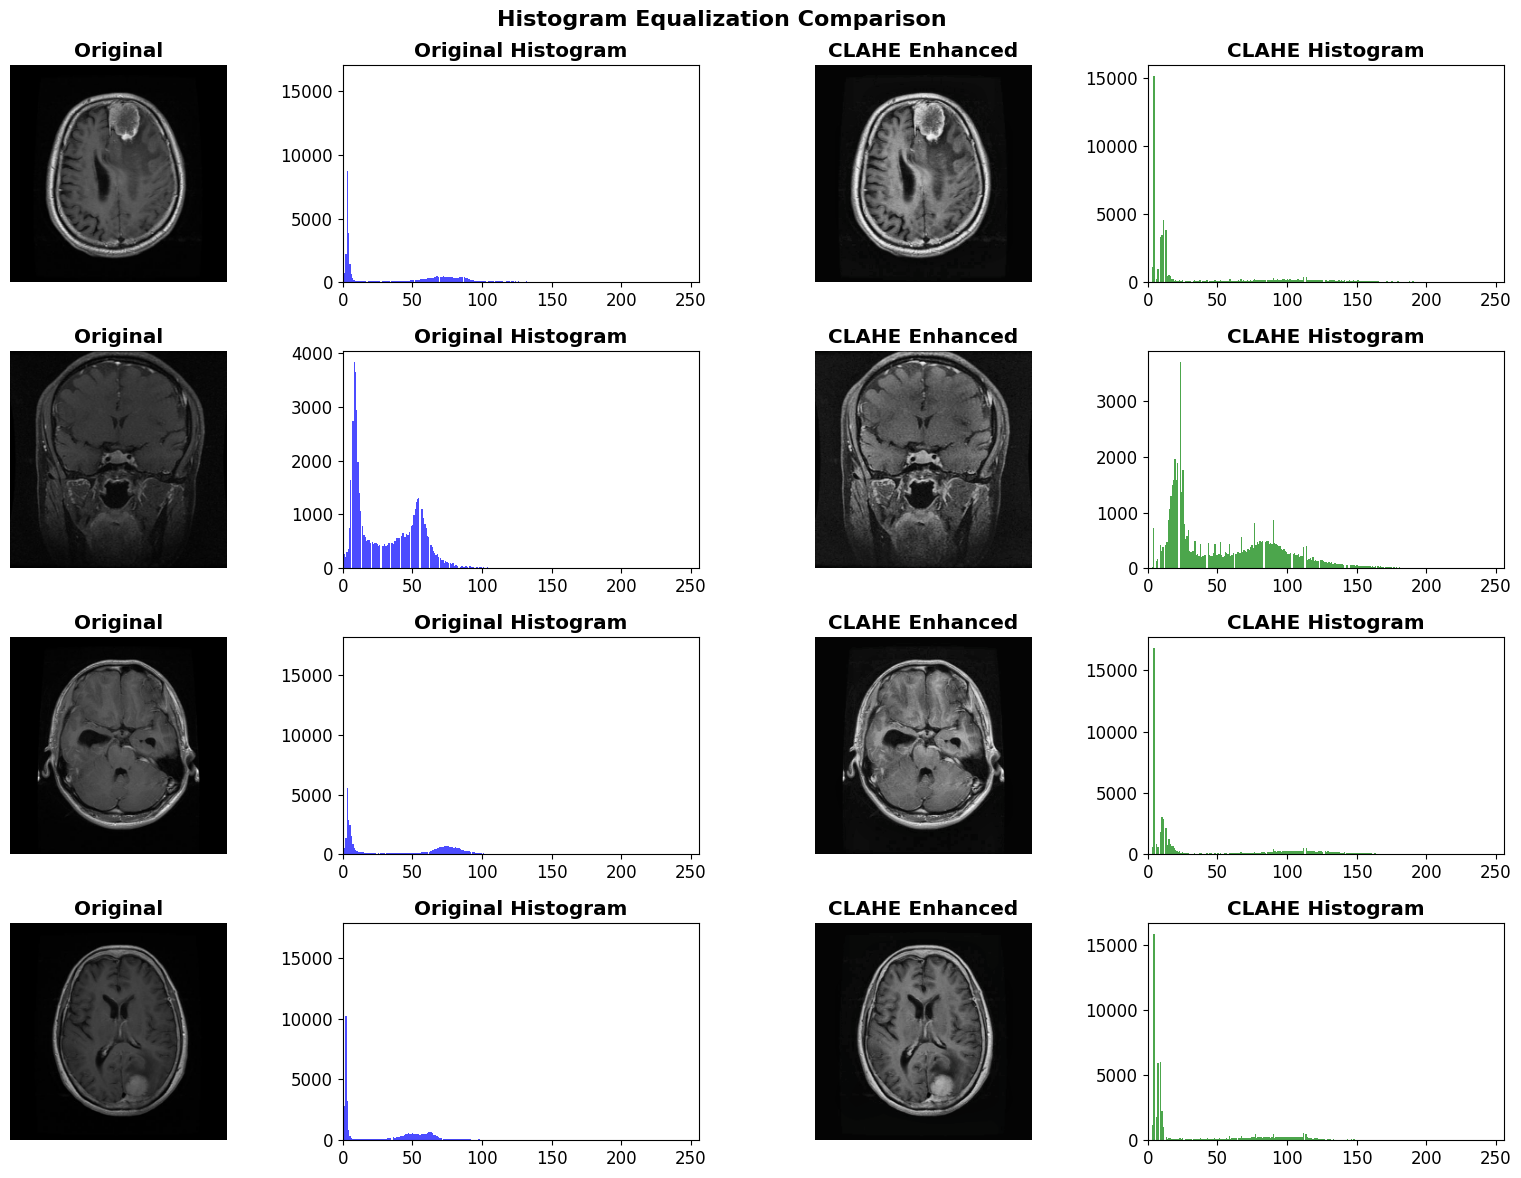

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))

for i in range(4):
    idx = np.random.randint(0, len(train_images_original))

    axes[i, 0].imshow(train_images_original[idx])
    axes[i, 0].set_title('Original', fontweight='bold')
    axes[i, 0].axis('off')

    gray_orig = cv2.cvtColor(train_images_original[idx], cv2.COLOR_RGB2GRAY)
    axes[i, 1].hist(gray_orig.ravel(), bins=256, color='blue', alpha=0.7)
    axes[i, 1].set_title('Original Histogram', fontweight='bold')
    axes[i, 1].set_xlim([0, 256])

    axes[i, 2].imshow(train_images_clahe[idx])
    axes[i, 2].set_title('CLAHE Enhanced', fontweight='bold')
    axes[i, 2].axis('off')

    gray_clahe = cv2.cvtColor(train_images_clahe[idx], cv2.COLOR_RGB2GRAY)
    axes[i, 3].hist(gray_clahe.ravel(), bins=256, color='green', alpha=0.7)
    axes[i, 3].set_title('CLAHE Histogram', fontweight='bold')
    axes[i, 3].set_xlim([0, 256])

plt.suptitle('Histogram Equalization Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('histogram_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


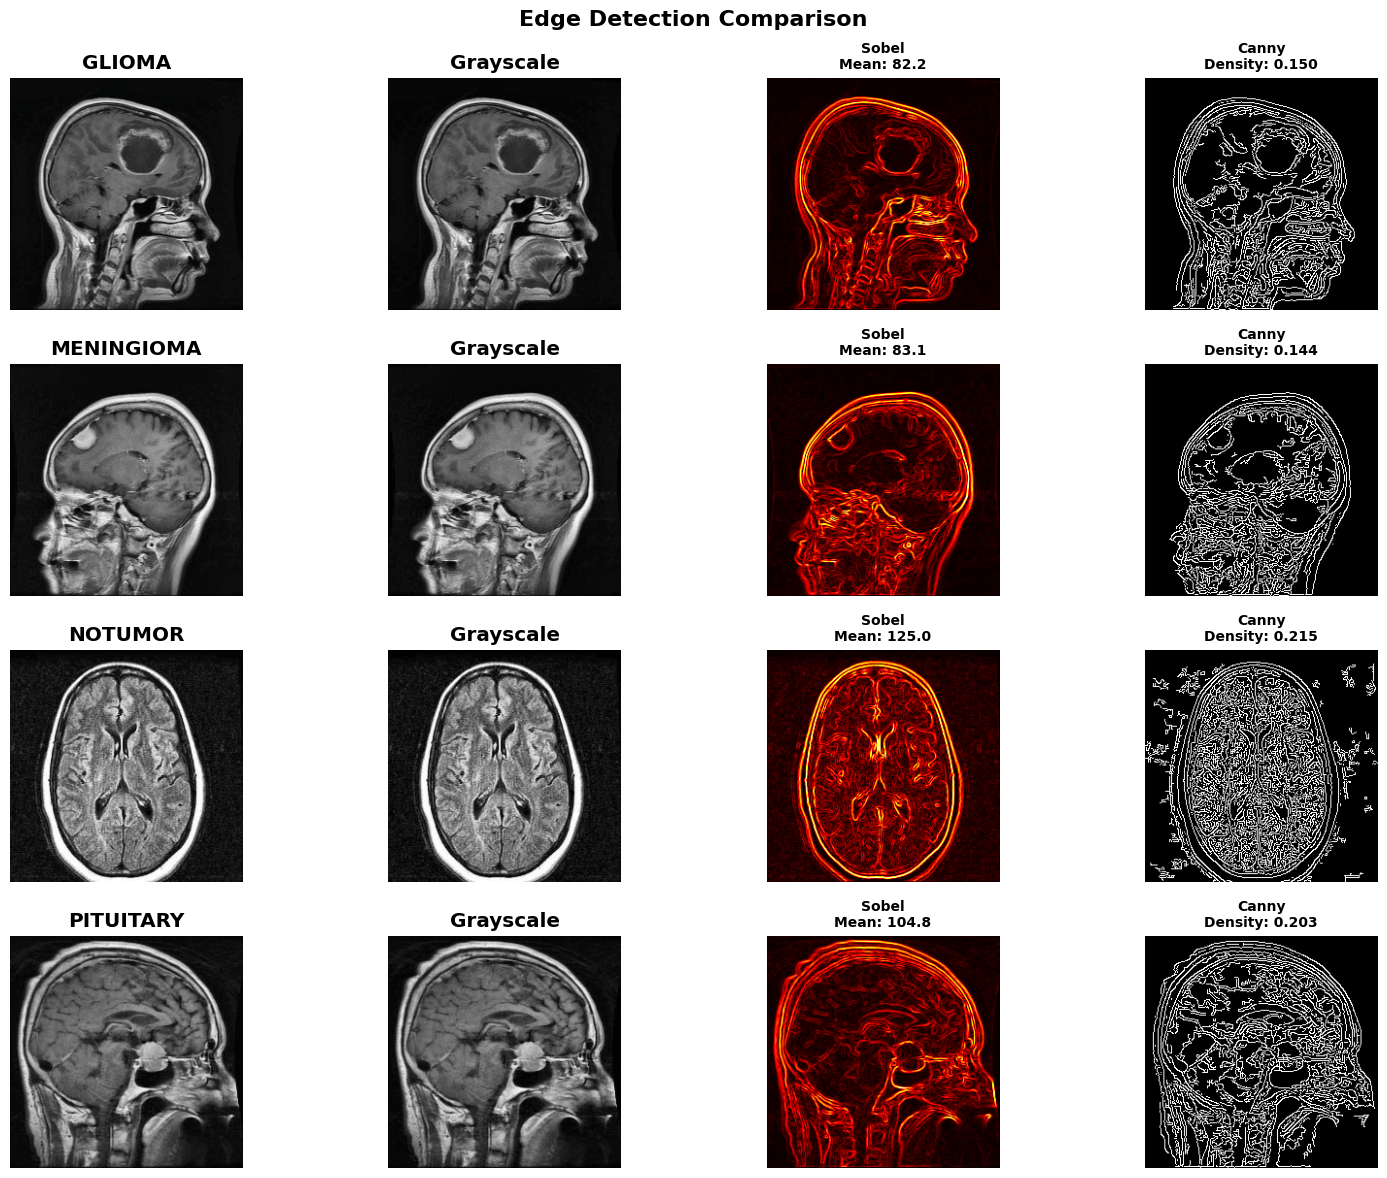

In [7]:
def extract_edge_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)

    canny = cv2.Canny(gray, 50, 150)

    features = {
        'sobel_mean': np.mean(sobel_magnitude),
        'sobel_std': np.std(sobel_magnitude),
        'edge_density': np.sum(canny > 0) / canny.size,
        'edge_mean_intensity': np.mean(sobel_magnitude[canny > 0]) if np.sum(canny > 0) > 0 else 0
    }

    return features, sobel_magnitude, canny

fig, axes = plt.subplots(4, 4, figsize=(16, 12))

for i, class_name in enumerate(CLASS_TYPES):
    class_idx = np.where(train_labels == class_name)[0][0]
    img = train_images_clahe[class_idx]
    edge_features, sobel, canny = extract_edge_features(img)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'{class_name.upper()}', fontweight='bold')
    axes[i, 0].axis('off')

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    axes[i, 1].imshow(gray, cmap='gray')
    axes[i, 1].set_title('Grayscale', fontweight='bold')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(sobel, cmap='hot')
    axes[i, 2].set_title(f'Sobel\nMean: {edge_features["sobel_mean"]:.1f}',
                         fontweight='bold', fontsize=10)
    axes[i, 2].axis('off')

    axes[i, 3].imshow(canny, cmap='gray')
    axes[i, 3].set_title(f'Canny\nDensity: {edge_features["edge_density"]:.3f}',
                         fontweight='bold', fontsize=10)
    axes[i, 3].axis('off')

plt.suptitle('Edge Detection Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('edge_detection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Extracted 12 GLCM features


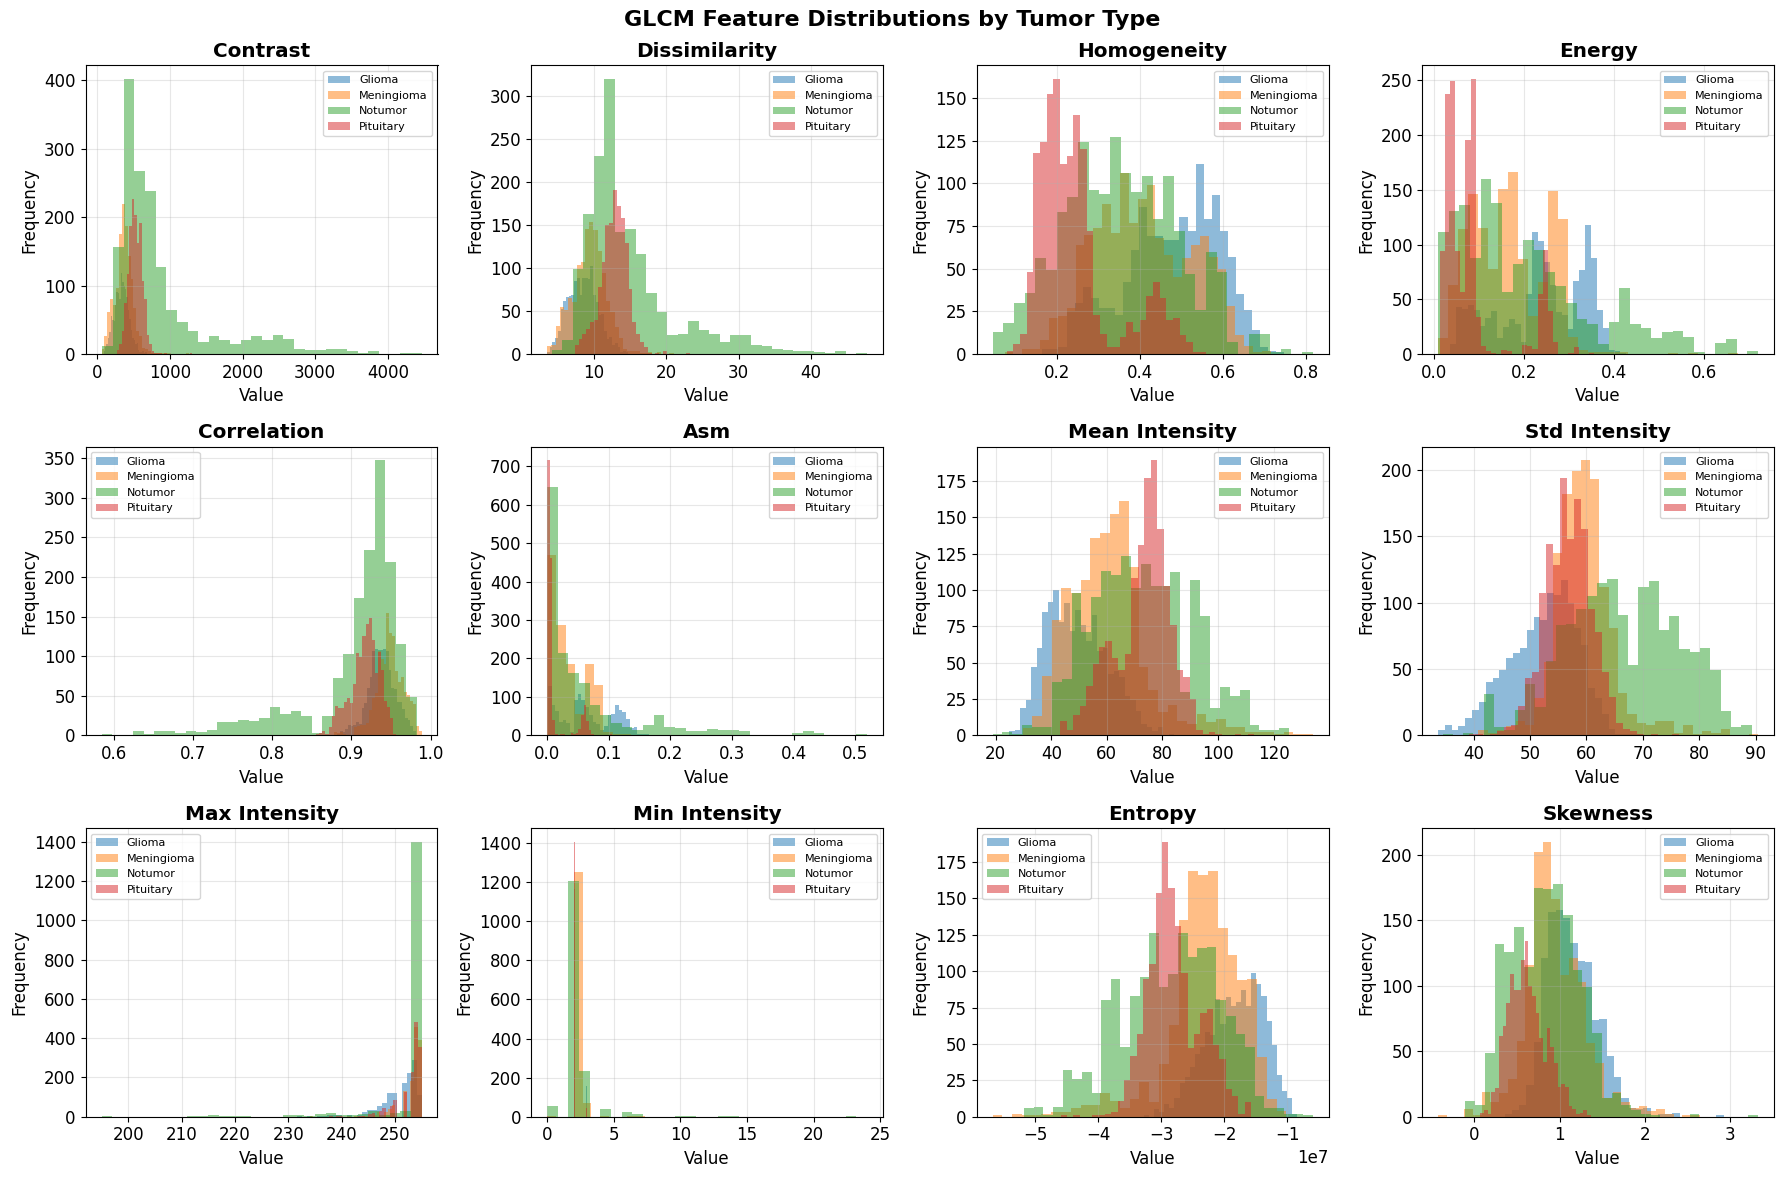

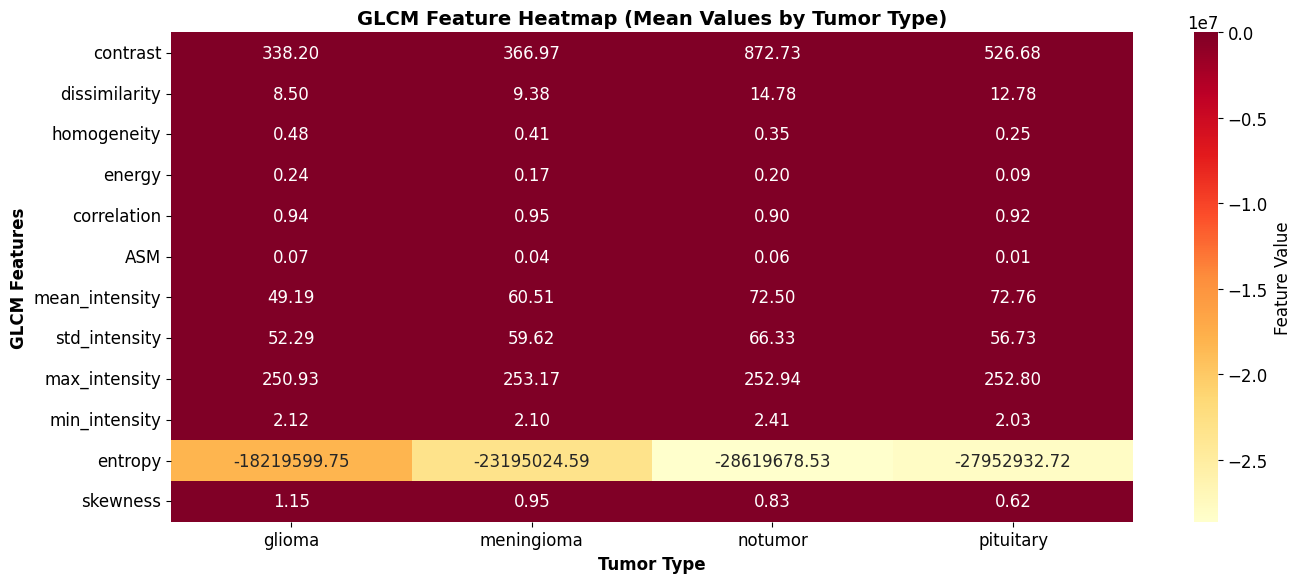

In [8]:
def extract_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)

    features = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
        'ASM': graycoprops(glcm, 'ASM').mean(),
        'mean_intensity': np.mean(gray),
        'std_intensity': np.std(gray),
        'max_intensity': np.max(gray),
        'min_intensity': np.min(gray),
        'entropy': -np.sum(gray * np.log2(gray + 1e-10)),
        'skewness': np.mean(((gray - np.mean(gray)) / (np.std(gray) + 1e-10))**3)
    }
    return features

train_glcm_features = [extract_glcm_features(img) for img in train_images_clahe]
train_glcm_df = pd.DataFrame(train_glcm_features)
train_glcm_df['label'] = train_labels

test_glcm_features = [extract_glcm_features(img) for img in test_images_clahe]
test_glcm_df = pd.DataFrame(test_glcm_features)
test_glcm_df['label'] = test_labels

print(f"Extracted {len(train_glcm_df.columns)-1} GLCM features")
feature_cols = [col for col in train_glcm_df.columns if col != 'label']

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.ravel()
for i, feature in enumerate(feature_cols):
    for class_name in CLASS_TYPES:
        class_data = train_glcm_df[train_glcm_df['label'] == class_name][feature]
        axes[i].hist(class_data, bins=30, alpha=0.5, label=class_name.title())
    axes[i].set_title(feature.replace('_', ' ').title(), fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend(fontsize=8)
    axes[i].grid(alpha=0.3)
plt.suptitle('GLCM Feature Distributions by Tumor Type',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('glcm_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

mean_features = train_glcm_df.groupby('label')[feature_cols].mean()
plt.figure(figsize=(14, 6))
sns.heatmap(mean_features.T, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Feature Value'})
plt.title('GLCM Feature Heatmap (Mean Values by Tumor Type)',
          fontsize=14, fontweight='bold')
plt.xlabel('Tumor Type', fontweight='bold')
plt.ylabel('GLCM Features', fontweight='bold')
plt.tight_layout()
plt.savefig('glcm_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


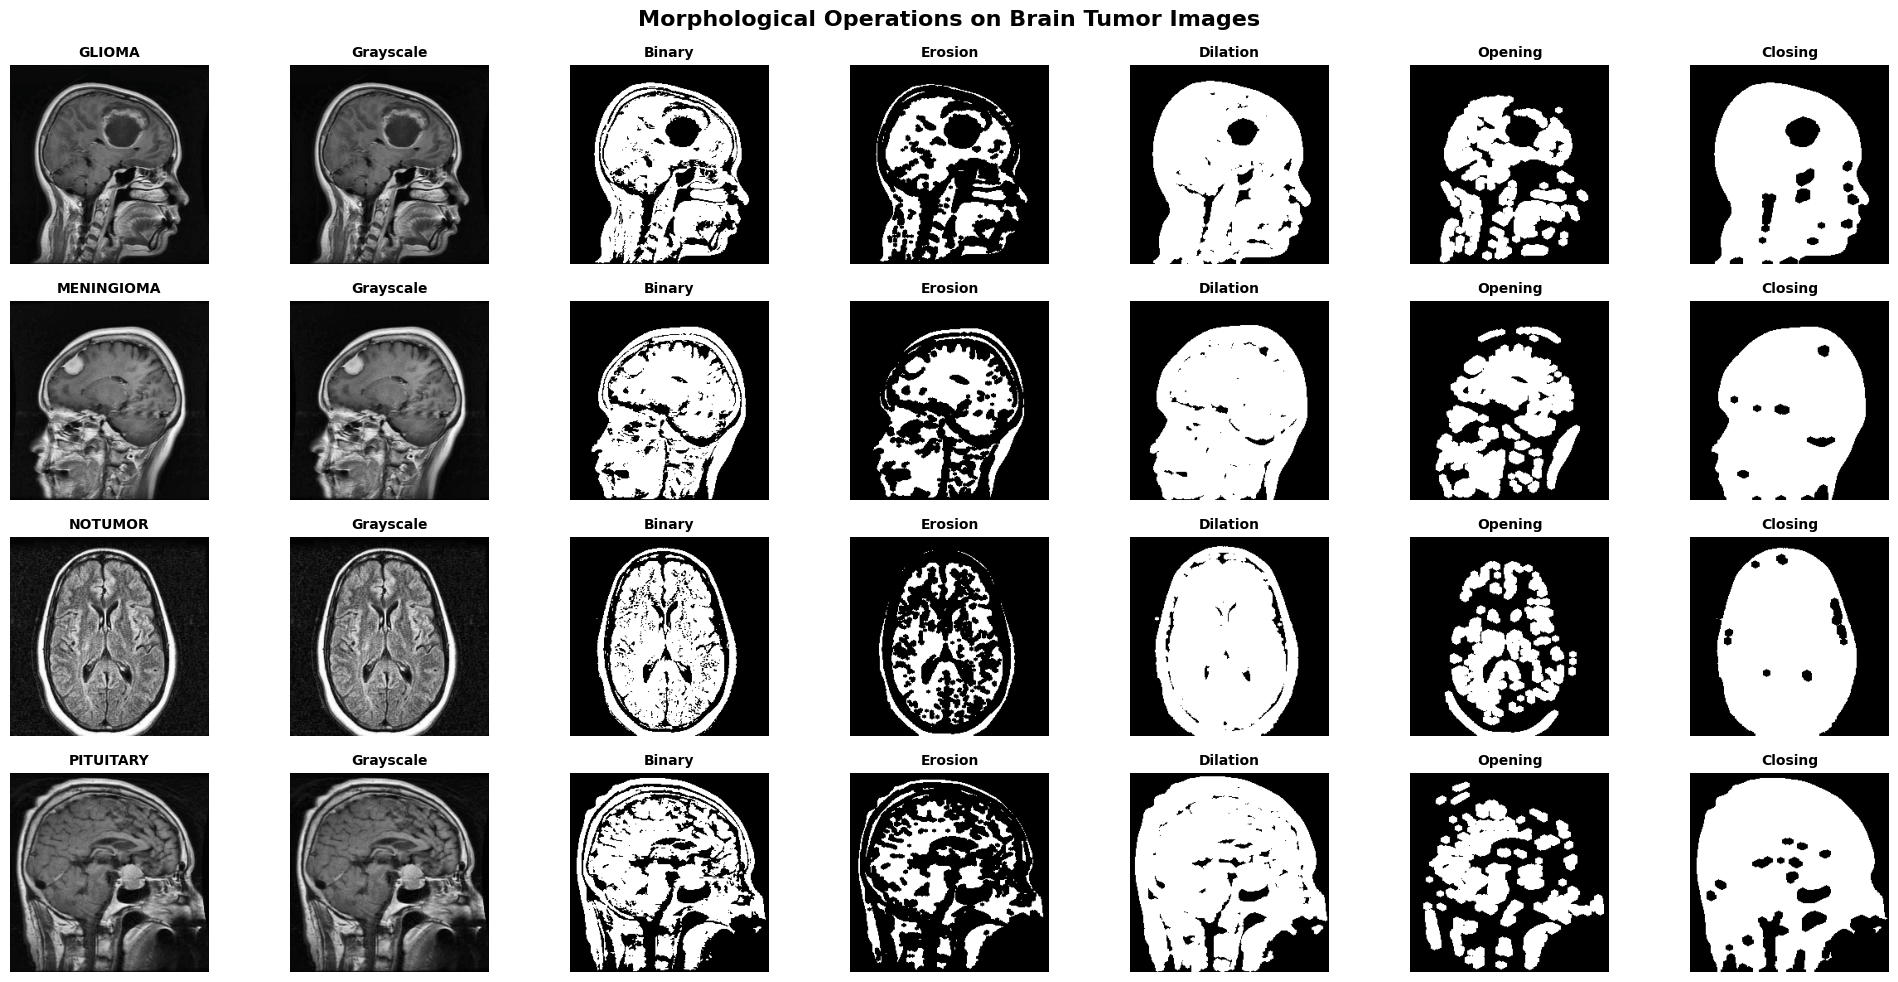

In [9]:
def apply_morphological_operations(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    erosion = cv2.erode(binary, kernel, iterations=1)
    dilation = cv2.dilate(binary, kernel, iterations=1)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
    gradient = cv2.morphologyEx(binary, cv2.MORPH_GRADIENT, kernel)

    return {
        'original': gray,
        'binary': binary,
        'erosion': erosion,
        'dilation': dilation,
        'opening': opening,
        'closing': closing,
        'gradient': gradient
    }

fig, axes = plt.subplots(4, 7, figsize=(20, 10))
for i, class_name in enumerate(CLASS_TYPES):
    class_idx = np.where(train_labels == class_name)[0][0]
    img = train_images_clahe[class_idx]
    morph_results = apply_morphological_operations(img)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'{class_name.upper()}', fontweight='bold', fontsize=10)
    axes[i, 0].axis('off')

    axes[i, 1].imshow(morph_results['original'], cmap='gray')
    axes[i, 1].set_title('Grayscale', fontweight='bold', fontsize=10)
    axes[i, 1].axis('off')

    axes[i, 2].imshow(morph_results['binary'], cmap='gray')
    axes[i, 2].set_title('Binary', fontweight='bold', fontsize=10)
    axes[i, 2].axis('off')

    axes[i, 3].imshow(morph_results['erosion'], cmap='gray')
    axes[i, 3].set_title('Erosion', fontweight='bold', fontsize=10)
    axes[i, 3].axis('off')

    axes[i, 4].imshow(morph_results['dilation'], cmap='gray')
    axes[i, 4].set_title('Dilation', fontweight='bold', fontsize=10)
    axes[i, 4].axis('off')

    axes[i, 5].imshow(morph_results['opening'], cmap='gray')
    axes[i, 5].set_title('Opening', fontweight='bold', fontsize=10)
    axes[i, 5].axis('off')

    axes[i, 6].imshow(morph_results['closing'], cmap='gray')
    axes[i, 6].set_title('Closing', fontweight='bold', fontsize=10)
    axes[i, 6].axis('off')

plt.suptitle('Morphological Operations on Brain Tumor Images',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('morphological_operations.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
def extract_morphological_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    clahe_temp = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe_temp.apply(gray)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    labeled = label(binary)
    regions = regionprops(labeled)
    if len(regions) == 0:
        return {
            'area': 0, 'perimeter': 0, 'circularity': 0, 'eccentricity': 0,
            'solidity': 0, 'extent': 0, 'major_axis': 0, 'minor_axis': 0
        }
    region = max(regions, key=lambda r: r.area)
    perimeter = region.perimeter
    area = region.area
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

    features = {
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'eccentricity': region.eccentricity,
        'solidity': region.solidity,
        'extent': region.extent,
        'major_axis': region.major_axis_length,
        'minor_axis': region.minor_axis_length
    }
    return features

train_morph_features = [extract_morphological_features(img) for img in train_images_clahe]
train_morph_df = pd.DataFrame(train_morph_features)

test_morph_features = [extract_morphological_features(img) for img in test_images_clahe]
test_morph_df = pd.DataFrame(test_morph_features)

print(f"Extracted {len(train_morph_df.columns)} morphological features")

train_edge_features = []
for img in train_images_clahe:
    features, _, _ = extract_edge_features(img)
    train_edge_features.append(features)
train_edge_df = pd.DataFrame(train_edge_features)

test_edge_features = []
for img in test_images_clahe:
    features, _, _ = extract_edge_features(img)
    test_edge_features.append(features)
test_edge_df = pd.DataFrame(test_edge_features)

X_train_traditional = pd.concat([
    train_glcm_df.drop('label', axis=1),
    train_morph_df,
    train_edge_df
], axis=1)
y_train_traditional = train_labels_encoded

X_test_traditional = pd.concat([
    test_glcm_df.drop('label', axis=1),
    test_morph_df,
    test_edge_df
], axis=1)
y_test_traditional = test_labels_encoded

X_train_traditional = X_train_traditional.fillna(0)
X_test_traditional = X_test_traditional.fillna(0)

print(f"Total handcrafted features: {X_train_traditional.shape[1]}")
print(f"Training samples: {X_train_traditional.shape[0]}")
print(f"Test samples: {X_test_traditional.shape[0]}")


Extracted 8 morphological features
Total handcrafted features: 24
Training samples: 5712
Test samples: 1311


In [11]:
custom_objects = {
    'CBAM': CBAM,
    'ChannelAttention': ChannelAttention,
    'SpatialAttention': SpatialAttention
}

print("Loading trained models...")
model_v1 = keras.models.load_model('model_v1_no_preprocessing.h5', custom_objects=custom_objects)
model_v2 = keras.models.load_model('model_v2_clahe.h5', custom_objects=custom_objects)
model_v3 = keras.models.load_model('model_v3_preprocessing.h5', custom_objects=custom_objects)

history_v1 = np.load('history_v1.npy', allow_pickle=True).item()
history_v2 = np.load('history_v2.npy', allow_pickle=True).item()
history_v3 = np.load('history_v3.npy', allow_pickle=True).item()

y_pred_v1 = np.load('y_pred_v1.npy')
y_pred_v2 = np.load('y_pred_v2.npy')
y_pred_v3 = np.load('y_pred_v3.npy')

y_pred_v1_classes = np.argmax(y_pred_v1, axis=1)
y_pred_v2_classes = np.argmax(y_pred_v2, axis=1)
y_pred_v3_classes = np.argmax(y_pred_v3, axis=1)

accuracy_v1 = accuracy_score(test_labels_encoded, y_pred_v1_classes)
accuracy_v2 = accuracy_score(test_labels_encoded, y_pred_v2_classes)
accuracy_v3 = accuracy_score(test_labels_encoded, y_pred_v3_classes)


Loading trained models...


In [12]:
m_a, m_b, m_c = model_v1, model_v2, model_v3
h_a, h_b, h_c = history_v1, history_v2, history_v3
p_a, p_b, p_c = y_pred_v1, y_pred_v2, y_pred_v3
pc_a, pc_b, pc_c = y_pred_v1_classes, y_pred_v2_classes, y_pred_v3_classes
acc_a, acc_b, acc_c = accuracy_v1, accuracy_v2, accuracy_v3

model_v1 = m_c
history_v1 = h_c
y_pred_v1 = p_c
y_pred_v1_classes = pc_c
accuracy_v1 = acc_c

model_v2 = m_a
history_v2 = h_a
y_pred_v2 = p_a
y_pred_v2_classes = pc_a
accuracy_v2 = acc_a

model_v3 = m_b
history_v3 = h_b
y_pred_v3 = p_b
y_pred_v3_classes = pc_b
accuracy_v3 = acc_b


In [13]:
print(f"Version 1 Accuracy: {accuracy_v1*100:.6f}%")
print(f"Version 2 Accuracy: {accuracy_v2*100:.6f}%")
print(f"Version 3 Accuracy: {accuracy_v3*100:.6f}%")

Version 1 Accuracy: 98.245614%
Version 2 Accuracy: 98.703280%
Version 3 Accuracy: 98.932113%


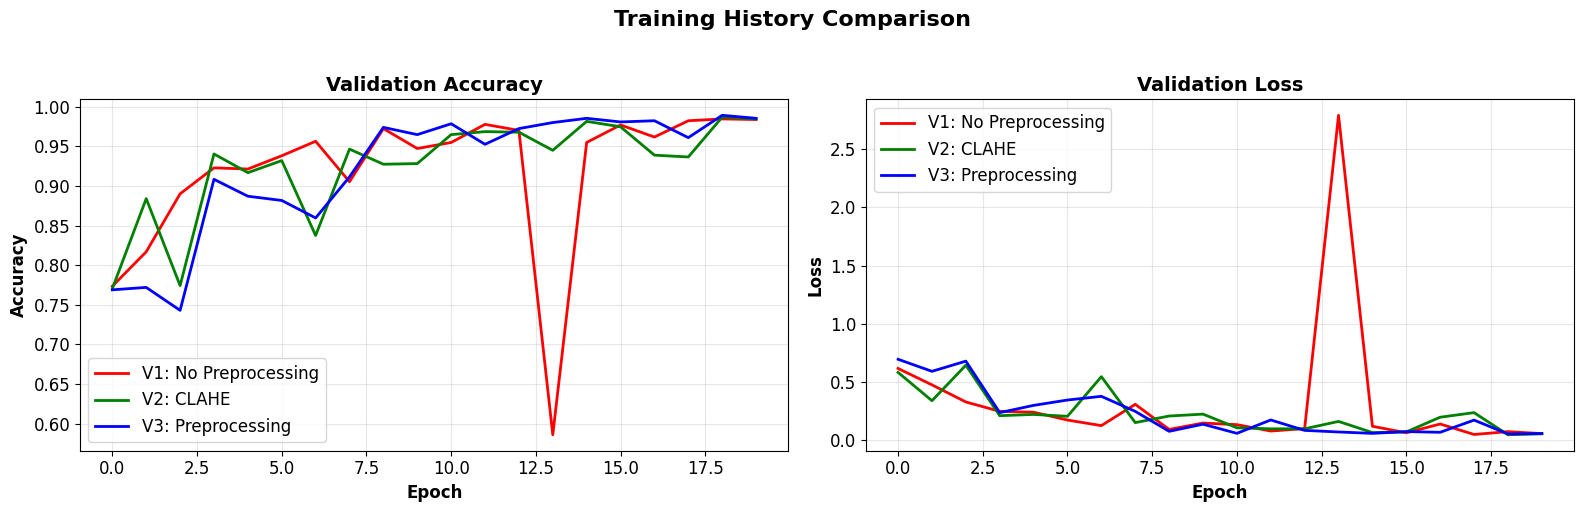

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history_v1['val_accuracy'], 'r-', linewidth=2, label='V1: No Preprocessing')
axes[0].plot(history_v2['val_accuracy'], 'g-', linewidth=2, label='V2: CLAHE')
axes[0].plot(history_v3['val_accuracy'], 'b-', linewidth=2, label='V3: Preprocessing')
axes[0].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Accuracy', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(history_v1['val_loss'], 'r-', linewidth=2, label='V1: No Preprocessing')
axes[1].plot(history_v2['val_loss'], 'g-', linewidth=2, label='V2: CLAHE')
axes[1].plot(history_v3['val_loss'], 'b-', linewidth=2, label='V3: Preprocessing')
axes[1].set_title('Validation Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Loss', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Training History Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()


Model v1
Test Accuracy: 98.25%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.97      0.97       300
  meningioma       0.96      0.97      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



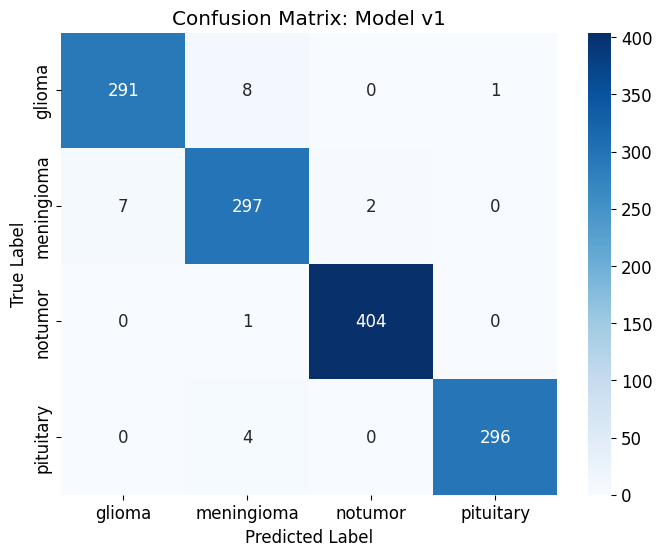

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

print("Model v1")
print("="*60)
print(f"Test Accuracy: {accuracy_v1*100:.2f}%\n")

report_v1 = classification_report(test_labels_encoded, y_pred_v1_classes, target_names=CLASS_TYPES)
print("Classification Report:")
print(report_v1)

cm_v1 = confusion_matrix(test_labels_encoded, y_pred_v1_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm_v1, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_TYPES, yticklabels=CLASS_TYPES)
plt.title('Confusion Matrix: Model v1')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Model v2
Test Accuracy: 98.70%

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      0.97      0.97       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



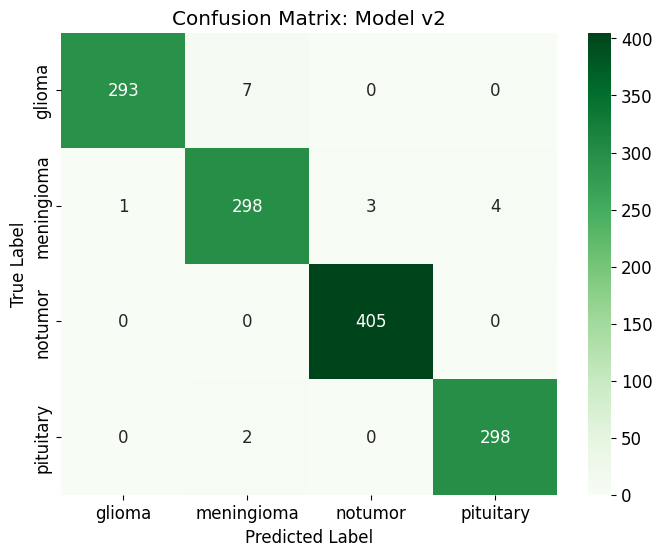

In [18]:
print("Model v2")
print("="*60)
print(f"Test Accuracy: {accuracy_v2*100:.2f}%\n")

report_v2 = classification_report(test_labels_encoded, y_pred_v2_classes, target_names=CLASS_TYPES)
print("Classification Report:")
print(report_v2)

cm_v2 = confusion_matrix(test_labels_encoded, y_pred_v2_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Greens', xticklabels=CLASS_TYPES, yticklabels=CLASS_TYPES)
plt.title('Confusion Matrix: Model v2')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Model v3
Test Accuracy: 98.93%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       300
  meningioma       0.98      0.98      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



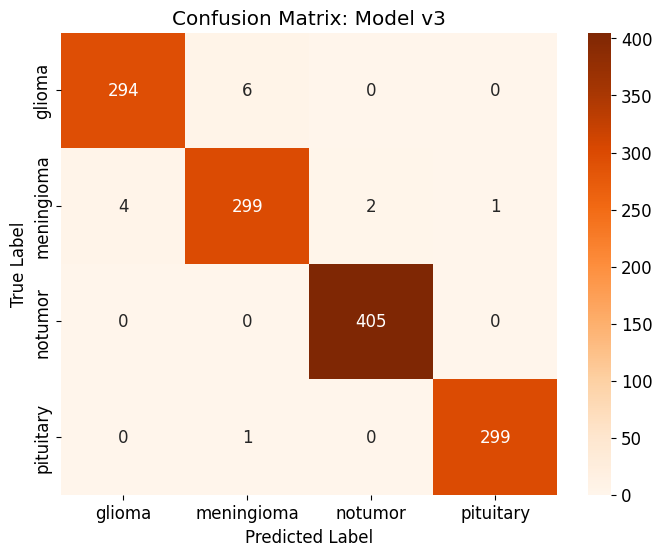

In [19]:
print("Model v3")
print("="*60)
print(f"Test Accuracy: {accuracy_v3*100:.2f}%\n")

report_v3 = classification_report(test_labels_encoded, y_pred_v3_classes, target_names=CLASS_TYPES)
print("Classification Report:")
print(report_v3)

cm_v3 = confusion_matrix(test_labels_encoded, y_pred_v3_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm_v3, annot=True, fmt='d', cmap='Oranges', xticklabels=CLASS_TYPES, yticklabels=CLASS_TYPES)
plt.title('Confusion Matrix: Model v3')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



Model Performance Comparison
                          Model  Accuracy (%)          Dataset Used
     U-Net+CBAM (Original Data)     98.245614  brain tumour dataset
U-Net+CBAM (CLAHE Preprocessed)     98.703280 brain tumour dataset1
      U-Net+CBAM (Preprocessed)     98.932113 brain tumour dataset1


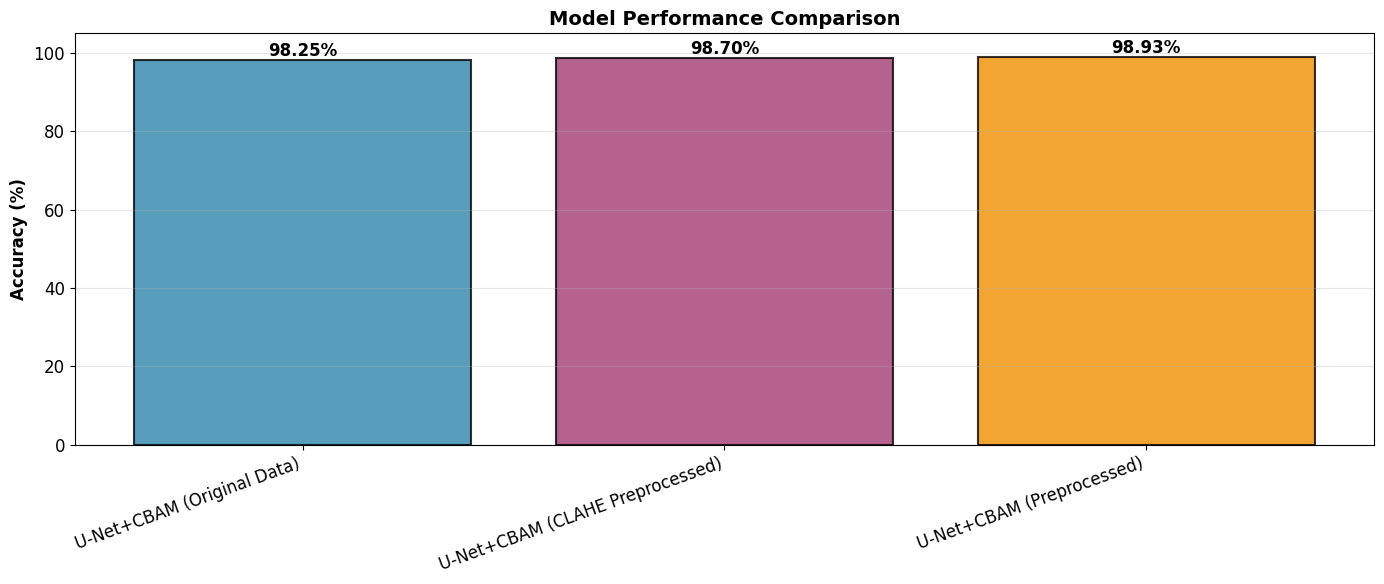

In [20]:
comparison_data = {
    'Model': [
        'U-Net+CBAM (Original Data)',
        'U-Net+CBAM (CLAHE Preprocessed)',
        'U-Net+CBAM (Preprocessed)'
    ],
    'Accuracy (%)': [
        accuracy_v1 * 100,
        accuracy_v2 * 100,
        accuracy_v3 * 100
    ],
    'Dataset Used': [
        'brain tumour dataset',
        'brain tumour dataset1',
        'brain tumour dataset1'
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\nModel Performance Comparison")
print("="*90)
print(df_comparison.to_string(index=False))
print("="*90)

fig, ax = plt.subplots(figsize=(14, 6))

models = df_comparison['Model'].values
accuracies = df_comparison['Accuracy (%)'].values
colors = ['#2E86AB', '#A23B72', '#F18F01']

bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%', ha='center', va='bottom',
            fontsize=12, fontweight='bold')

ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 105])
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.savefig('model_comparison_complete.png', dpi=300, bbox_inches='tight')
plt.show()

df_comparison.to_csv('model_comparison.csv', index=False)


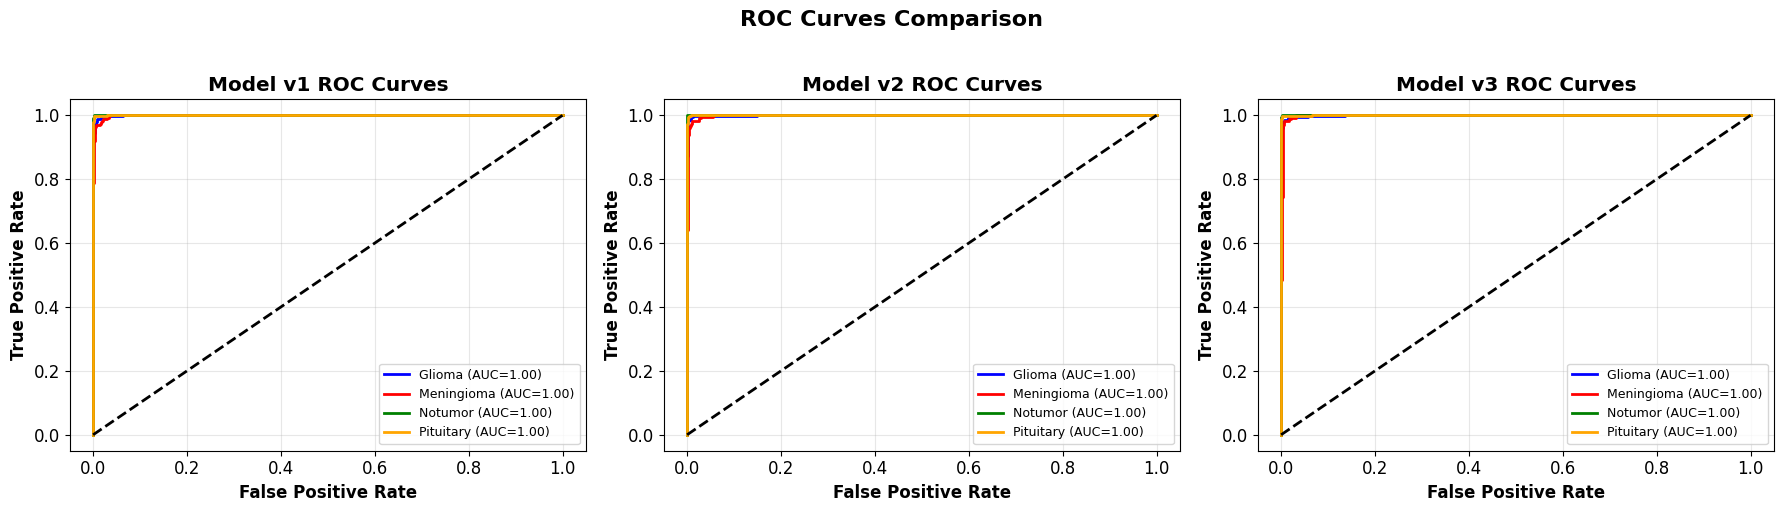

In [21]:
y_test_bin = label_binarize(test_labels_encoded, classes=range(N_TYPES))
colors = cycle(['blue', 'red', 'green', 'orange'])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, color in zip(range(N_TYPES), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_v1[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color=color, lw=2,
                 label=f'{CLASS_TYPES[i].title()} (AUC={roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlabel('False Positive Rate', fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontweight='bold')
axes[0].set_title('Model v1 ROC Curves', fontweight='bold')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(alpha=0.3)

for i, color in zip(range(N_TYPES), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_v2[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color=color, lw=2,
                 label=f'{CLASS_TYPES[i].title()} (AUC={roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlabel('False Positive Rate', fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontweight='bold')
axes[1].set_title('Model v2 ROC Curves', fontweight='bold')
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(alpha=0.3)

for i, color in zip(range(N_TYPES), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_v3[:, i])
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color=color, lw=2,
                 label=f'{CLASS_TYPES[i].title()} (AUC={roc_auc:.2f})')
axes[2].plot([0, 1], [0, 1], 'k--', lw=2)
axes[2].set_xlabel('False Positive Rate', fontweight='bold')
axes[2].set_ylabel('True Positive Rate', fontweight='bold')
axes[2].set_title('Model v3 ROC Curves', fontweight='bold')
axes[2].legend(loc='lower right', fontsize=9)
axes[2].grid(alpha=0.3)

plt.suptitle('ROC Curves Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


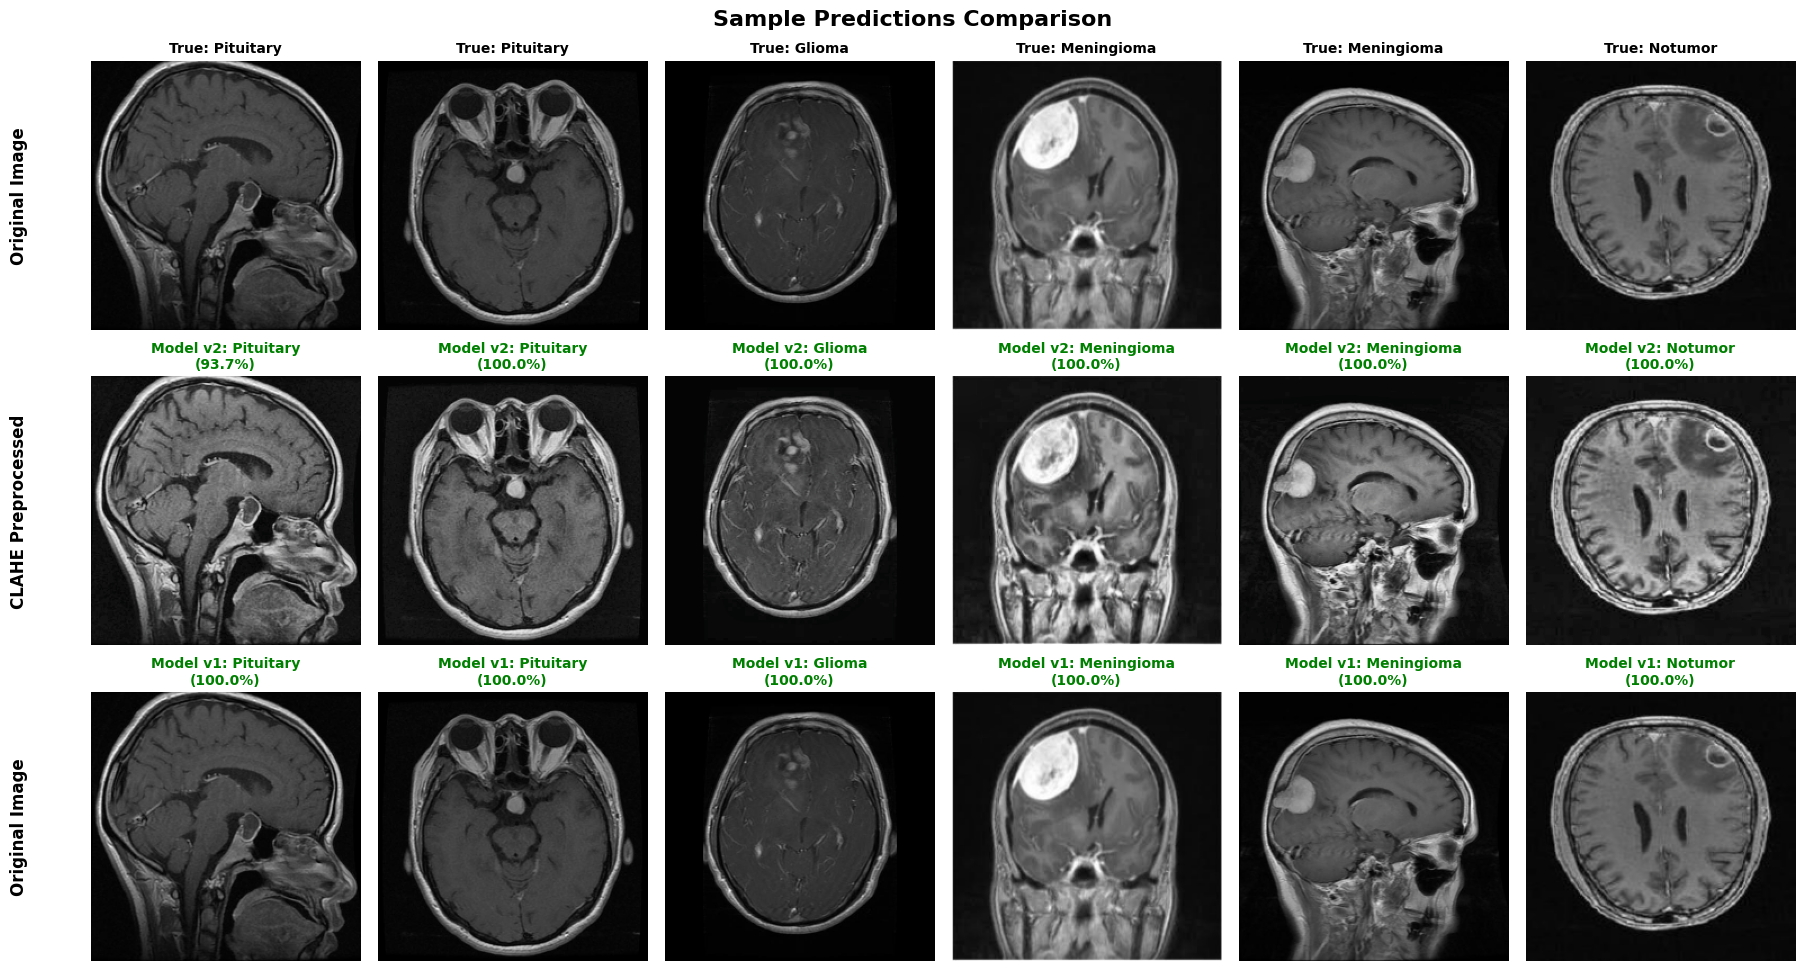

In [22]:
fig, axes = plt.subplots(3, 6, figsize=(18, 10))
np.random.seed(42)
sample_indices = np.random.choice(len(test_images_original), 6, replace=False)

for i, idx in enumerate(sample_indices):
    # Original images with true labels
    axes[0, i].imshow(test_images_original[idx])
    true_label = CLASS_TYPES[test_labels_encoded[idx]]
    axes[0, i].set_title(f'True: {true_label.title()}',
                        fontweight='bold', fontsize=10)
    axes[0, i].axis('off')

    # Model v2 predictions
    pred_label_v2 = CLASS_TYPES[y_pred_v2_classes[idx]]
    pred_conf_v2 = y_pred_v2[idx].max() * 100
    color_v2 = 'green' if pred_label_v2 == true_label else 'red'
    axes[1, i].imshow(test_images_clahe[idx])
    axes[1, i].set_title(f'Model v2: {pred_label_v2.title()}\n({pred_conf_v2:.1f}%)',
                        color=color_v2, fontweight='bold', fontsize=10)
    axes[1, i].axis('off')

    # Model v1 predictions
    pred_label_v1 = CLASS_TYPES[y_pred_v1_classes[idx]]
    pred_conf_v1 = y_pred_v1[idx].max() * 100
    color_v1 = 'green' if pred_label_v1 == true_label else 'red'
    axes[2, i].imshow(test_images_original[idx])
    axes[2, i].set_title(f'Model v1: {pred_label_v1.title()}\n({pred_conf_v1:.1f}%)',
                        color=color_v1, fontweight='bold', fontsize=10)
    axes[2, i].axis('off')

axes[0, 0].text(-0.3, 0.5, 'Original Image', transform=axes[0, 0].transAxes,
              fontsize=12, fontweight='bold', va='center', rotation=90)
axes[1, 0].text(-0.3, 0.5, 'CLAHE Preprocessed', transform=axes[1, 0].transAxes,
              fontsize=12, fontweight='bold', va='center', rotation=90)
axes[2, 0].text(-0.3, 0.5, 'Original Image', transform=axes[2, 0].transAxes,
              fontsize=12, fontweight='bold', va='center', rotation=90)

plt.suptitle('Sample Predictions Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()
